# Assignment 2 – Recommender Systems

**Name:**  
**PID:**  
**Dataset:** Food.com Recipes & Reviews (McAuley Lab Recommender Systems Datasets)

---

## 1. Dataset Selection & Exploratory Analysis

We use the **Food.com Recipes & Reviews** dataset from Julian McAuley’s Recommender Systems and Personalization Datasets page.

This dataset contains:
- ~231k recipes  
- ~226k users  
- ~1.1M reviews (user–recipe interactions)  

Each interaction includes:
- `user_id`, `recipe_id`
- integer `rating` from 1 to 5
- review `date`

Each recipe includes:
- `minutes`, `n_steps`, `n_ingredients`
- `nutrition` (list of [calories, total_fat, sugar, sodium, protein, sat_fat, carbs])
- title, description, ingredients, steps, tags, etc.

We will:
- Load recipes and interactions
- Compute basic statistics: number of users/items/interactions, sparsity, rating distribution, time span
- Use these to motivate our **features** and **predictive task**
#

In [75]:
%pip install --upgrade pip
%pip install numpy pandas matplotlib seaborn
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install ipykernel

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/torchvision-0.2.0-py2.py3-none-any.whl (48 kB)
ERROR: Could not find a version that satisfies the requirement torchaudio (from versions: none)
ERROR: No matching distribution found for torchaudio
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [76]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt

# For pretty printing
pd.set_option("display.max_columns", 50)

# === Adjust these paths to where you store the dataset ===
RECIPES_PATH = "RAW_recipes.csv"
INTERACTIONS_PATH = "RAW_interactions.csv"

recipes = pd.read_csv(RECIPES_PATH)
interactions = pd.read_csv(INTERACTIONS_PATH)

recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [77]:
interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


### 1.1 Basic dataset statistics
We first compute:
- Number of users
- Number of recipes
- Number of interactions
- Density / sparsity of the user–item matrix
- Rating distribution
- Time period covered

In [78]:
n_users = interactions["user_id"].nunique()
n_items = interactions["recipe_id"].nunique()
n_interactions = len(interactions)

print("Number of users:", n_users)
print("Number of recipes (items):", n_items)
print("Number of interactions (reviews):", n_interactions)

# Sparsity of the user–item matrix
total_possible = n_users * n_items
sparsity = 1 - (n_interactions / total_possible)
print(f"Sparsity of user–item matrix: {sparsity:.6f}")

Number of users: 226570
Number of recipes (items): 231637
Number of interactions (reviews): 1132367
Sparsity of user–item matrix: 0.999978


Rating distribution:
rating
0     60847
1     12818
2     14123
3     40855
4    187360
5    816364
Name: count, dtype: int64


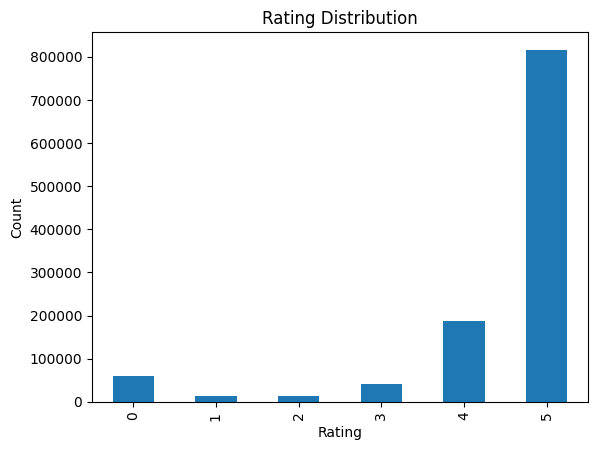

In [79]:
# Rating distribution
rating_counts = interactions["rating"].value_counts().sort_index()
print("Rating distribution:")
print(rating_counts)

plt.figure()
rating_counts.plot(kind="bar")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Distribution")
plt.show()

In [80]:
# Time period covered
interactions["date"] = pd.to_datetime(interactions["date"])
print("Earliest review date:", interactions["date"].min())
print("Latest review date:", interactions["date"].max())

Earliest review date: 2000-01-25 00:00:00
Latest review date: 2018-12-20 00:00:00


### 1.2 Interesting phenomena from exploratory analysis (to discuss in writeup)

Based on the above:
- The dataset is **large enough** to apply collaborative filtering and other models from class.  
- Ratings may be skewed towards high values (common in review data).  
- The dataset spans multiple years, so we can potentially do **time-based splits** (train on older, test on newer).  
- The user–item matrix is very sparse, which motivates using **matrix factorization** and other latent-factor methods.

We will use these observations to justify our **prediction task** and **feature choices**.
#

## 2. Predictive Task & Feature Engineering

### 2.1 Predictive Task

We define the following **binary classification task**:

> Given a user and a recipe, predict whether the user will give a **high rating (≥ 4)** to that recipe.

Formally, for each interaction `(user u, item i)` with rating `r`:
- `y = 1` if `r ≥ 4`
- `y = 0` otherwise

This is a standard setup in recommender systems, interpreting ratings 4–5 as “liked” and ≤3 as “not liked / neutral”.

We will evaluate our predictions using:
- **Accuracy**
- **AUC (Area Under ROC Curve)**
- Optionally, **F1-score** for class-imbalance sensitivity.
#

In [81]:
interactions["label"] = (interactions["rating"] >= 4).astype(int)
interactions[["user_id", "recipe_id", "rating", "label"]].head()

,user_id,recipe_id,rating,label
0,38094,40893,4,1
1,1293707,40893,5,1
2,8937,44394,4,1
3,126440,85009,5,1
4,57222,85009,5,1


### 2.2 Merging interactions with recipe metadata

We join interactions with recipe metadata so we can build **content-based features** (recipe-level) and also support **collaborative filtering** (user–item IDs).
#

In [82]:
# Parse nutrition field into separate columns
# nutrition is a string like "[calories, total_fat, sugar, sodium, protein, sat_fat, carbs]"
recipes["nutrition_list"] = recipes["nutrition"].apply(literal_eval)

nutrition_cols = ["calories", "total_fat", "sugar", "sodium", "protein", "sat_fat", "carbs"]
for i, col in enumerate(nutrition_cols):
    recipes[col] = recipes["nutrition_list"].apply(lambda x: x[i] if len(x) > i else np.nan)

# Select recipe features of interest
recipe_features = [
    "id",              # recipe_id
    "minutes",
    "n_steps",
    "n_ingredients",
] + nutrition_cols

recipes_small = recipes[recipe_features]

# Merge
df = interactions.merge(recipes_small, left_on="recipe_id", right_on="id", how="inner")
df.head()

,user_id,recipe_id,date,rating,review,label,id,minutes,n_steps,n_ingredients,calories,total_fat,sugar,sodium,protein,sat_fat,carbs
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,1,40893,495,4,9,204.8,5.0,9.0,26.0,24.0,2.0,10.0
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",1,40893,495,4,9,204.8,5.0,9.0,26.0,24.0,2.0,10.0
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,1,44394,20,5,4,132.3,11.0,39.0,5.0,4.0,11.0,5.0
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,1,85009,10,3,13,2786.2,342.0,134.0,290.0,161.0,301.0,42.0
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",1,85009,10,3,13,2786.2,342.0,134.0,290.0,161.0,301.0,42.0


### 2.3 Content-based feature matrix

For the **content-based model**, we only use recipe features (no user IDs), so the same recipe always has the same predicted “likelihood of like”.  
This gives a strong **non-personalized baseline**.

We will use:
- `minutes`
- `n_steps`
- `n_ingredients`
- `calories`, `total_fat`, `sugar`, `sodium`, `protein`, `sat_fat`, `carbs`

We fill missing values with 0 for simplicity.
#

In [83]:
content_feature_cols = [
    "minutes", "n_steps", "n_ingredients"
] + nutrition_cols

X_content = df[content_feature_cols].fillna(0)
y = df["label"].values

X_content.head()

,minutes,n_steps,n_ingredients,calories,total_fat,sugar,sodium,protein,sat_fat,carbs
0,495,4,9,204.8,5.0,9.0,26.0,24.0,2.0,10.0
1,495,4,9,204.8,5.0,9.0,26.0,24.0,2.0,10.0
2,20,5,4,132.3,11.0,39.0,5.0,4.0,11.0,5.0
3,10,3,13,2786.2,342.0,134.0,290.0,161.0,301.0,42.0
4,10,3,13,2786.2,342.0,134.0,290.0,161.0,301.0,42.0


### 2.4 Train / validation / test split

To assess validity and significance of our results, we split the data into **train, validation, and test** sets.

- Train: used to fit the model  
- Validation: used for model/parameter selection (if needed)  
- Test: used for final evaluation  

We start with a simple random split; later we could explore time-based splits.
#

In [84]:
from sklearn.model_selection import train_test_split

X_train_c, X_temp_c, y_train, y_temp = train_test_split(
    X_content, y, test_size=0.3, random_state=42, stratify=y
)

X_valid_c, X_test_c, y_valid, y_test = train_test_split(
    X_temp_c, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

len(X_train_c), len(X_valid_c), len(X_test_c)

(792656, 169855, 169856)

In [85]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_c)
X_valid_scaled = scaler.transform(X_valid_c)
X_test_scaled = scaler.transform(X_test_c)

## 3. Models & Evaluation

We implement and compare:

1. **Logistic Regression (Content-Based Baseline)**  
   - Uses only recipe features (no user ID).  
   - A standard **classification model from class**.  
   - Answers: “Given the recipe’s properties, how likely is it to be liked on average?”

2. **Matrix Factorization (Collaborative Filtering)**  
   - Uses **user and item IDs** to learn low-dimensional embeddings.  
   - Captures personalized preferences.  
   - A standard **recommender model** from class.

We evaluate both with **Accuracy** and **AUC** on the held-out test set, and we discuss:
- Relevant baselines  
- Feature representations  
- Overfitting / scaling issues  
- Noise / missing data considerations  
#

### 3.1 Model 1 – Logistic Regression (Content-Based)

This is a **linear classifier**:

\[
\hat{y} = \sigma(w^\top x + b)
\]

Where:
- \( x \) = recipe feature vector  
- \( w \) = learned weights  
- \( \sigma \) = sigmoid function  

We expect this to capture **global tendencies** (e.g., very long, high-calorie recipes might be rated differently), but it cannot personalize to individual users.
#

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report

# Version 1: Default (no class weighting)
lr_default = LogisticRegression(max_iter=5000)
lr_default.fit(X_train_scaled, y_train)

# Version 2: Balanced class weights
lr_balanced = LogisticRegression(class_weight='balanced', max_iter=5000)
lr_balanced.fit(X_train_scaled, y_train)

# Validation - Default
valid_probs_default = lr_default.predict_proba(X_valid_scaled)[:, 1]
valid_preds_default = (valid_probs_default >= 0.5).astype(int)
print("=== LR Default (no class weighting) ===")
print("Validation Accuracy:", accuracy_score(y_valid, valid_preds_default))
print("Validation AUC:", roc_auc_score(y_valid, valid_probs_default))

# Validation - Balanced
valid_probs_balanced = lr_balanced.predict_proba(X_valid_scaled)[:, 1]
valid_preds_balanced = (valid_probs_balanced >= 0.5).astype(int)
print("\n=== LR Balanced (class_weight='balanced') ===")
print("Validation Accuracy:", accuracy_score(y_valid, valid_preds_balanced))
print("Validation AUC:", roc_auc_score(y_valid, valid_probs_balanced))

=== LR Default (no class weighting) ===
Validation Accuracy: 0.886379559035648
Validation AUC: 0.5198788612075813

=== LR Balanced (class_weight='balanced') ===
Validation Accuracy: 0.6061581937534957
Validation AUC: 0.5201822080016409


In [87]:
# Trivial baseline
trivial_acc = y_test.mean()
print("=== Trivial Baseline (always predict 1) ===")
print(f"Accuracy: {trivial_acc:.4f}, AUC: 0.5000\n")

# Test - Default LR
test_probs_default = lr_default.predict_proba(X_test_scaled)[:, 1]  # FIX: use scaled data
test_preds_default = (test_probs_default >= 0.5).astype(int)
print("=== LR Default (Test) ===")
print("Accuracy:", accuracy_score(y_test, test_preds_default))
print("AUC:", roc_auc_score(y_test, test_probs_default))
print("F1:", f1_score(y_test, test_preds_default))
print(classification_report(y_test, test_preds_default))

# Test - Balanced LR
test_probs_balanced = lr_balanced.predict_proba(X_test_scaled)[:, 1]  # FIX: use scaled data
test_preds_balanced = (test_probs_balanced >= 0.5).astype(int)
print("=== LR Balanced (Test) ===")
print("Accuracy:", accuracy_score(y_test, test_preds_balanced))
print("AUC:", roc_auc_score(y_test, test_probs_balanced))
print("F1:", f1_score(y_test, test_preds_balanced))
print(classification_report(y_test, test_preds_balanced))

=== Trivial Baseline (always predict 1) ===
Accuracy: 0.8864, AUC: 0.5000

=== LR Default (Test) ===
Accuracy: 0.8863978899773927
AUC: 0.5228434205651878
F1: 0.9397775364218569
              precision    recall  f1-score   support

           0       0.67      0.00      0.00     19297
           1       0.89      1.00      0.94    150559

    accuracy                           0.89    169856
   macro avg       0.78      0.50      0.47    169856
weighted avg       0.86      0.89      0.83    169856

=== LR Balanced (Test) ===
Accuracy: 0.6041588168801808
AUC: 0.523404789689351
F1: 0.7382855986236211
              precision    recall  f1-score   support

           0       0.12      0.40      0.19     19297
           1       0.89      0.63      0.74    150559

    accuracy                           0.60    169856
   macro avg       0.51      0.52      0.46    169856
weighted avg       0.80      0.60      0.68    169856



#### Notes:
- This model is **fast and scalable** even on large datasets.  
- It provides interpretable coefficients, which we’ll analyze in Section 5.  
- It ignores user identity, so it fails to capture “user A likes spicy food, user B doesn’t”.

Next, we move to a **collaborative filtering** model that incorporates user and item IDs.
#

### 3.2 Preparing data for Matrix Factorization

For MF, we need:
- Integer-encoded `user_id`
- Integer-encoded `recipe_id`
- Binary label `y` (like vs not like)

We will re-split the data into train/valid/test on the **full interaction data** with user and item IDs.
#

In [88]:
from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df["user_idx"] = user_encoder.fit_transform(df["user_id"])
df["item_idx"] = item_encoder.fit_transform(df["recipe_id"])

n_users = df["user_idx"].nunique()
n_items = df["item_idx"].nunique()

print("Number of encoded users:", n_users)
print("Number of encoded items:", n_items)

Number of encoded users: 226570
Number of encoded items: 231637


In [89]:
# Create arrays for MF
u_all = df["user_idx"].values
i_all = df["item_idx"].values
y_all = df["label"].values

u_train, u_temp, i_train, i_temp, y_train_cf, y_temp_cf = train_test_split(
    u_all, i_all, y_all, test_size=0.3, random_state=42, stratify=y_all
)

u_valid, u_test, i_valid, i_test, y_valid_cf, y_test_cf = train_test_split(
    u_temp, i_temp, y_temp_cf, test_size=0.5, random_state=42, stratify=y_temp_cf
)

len(u_train), len(u_valid), len(u_test)

(792656, 169855, 169856)

### 3.3 Model 2 – Matrix Factorization (Collaborative Filtering)

We implement a simple MF model using PyTorch:

- Each user \( u \) has embedding vector \( p_u \in \mathbb{R}^k \).  
- Each item \( i \) has embedding vector \( q_i \in \mathbb{R}^k \).  
- Predicted probability of a “like”:

\[
\hat{y}_{ui} = \sigma(p_u^\top q_i)
\]

We train with **binary cross-entropy loss**.

This is the standard latent factor model from class, adapted for binary labels.
#

In [90]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [91]:
class InteractionDataset(Dataset):
    def __init__(self, users, items, labels):
        self.users = users
        self.items = items
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.users[idx]).long(),
            torch.tensor(self.items[idx]).long(),
            torch.tensor(self.labels[idx]).float()
        )

train_dataset = InteractionDataset(u_train, i_train, y_train_cf)
valid_dataset = InteractionDataset(u_valid, i_valid, y_valid_cf)
test_dataset  = InteractionDataset(u_test,  i_test,  y_test_cf)

train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4096, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=4096, shuffle=False)

In [92]:
class MFModel(nn.Module):
    def __init__(self, n_users, n_items, k=32):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, k)
        self.item_emb = nn.Embedding(n_items, k)
        self.sigmoid = nn.Sigmoid()

        # Optional: initialize embeddings
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)

    def forward(self, u, i):
        u_vec = self.user_emb(u)
        i_vec = self.item_emb(i)
        dot = (u_vec * i_vec).sum(dim=1)
        return self.sigmoid(dot)

In [93]:
model = MFModel(n_users=n_users, n_items=n_items, k=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [94]:
def evaluate_mf(model, data_loader):
    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for u, it, labels in data_loader:
            u = u.to(device)
            it = it.to(device)
            labels = labels.to(device)
            probs = model(u, it)
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)
    preds = (all_probs >= 0.5).astype(int)

    acc = accuracy_score(all_labels, preds)
    auc = roc_auc_score(all_labels, all_probs)
    f1  = f1_score(all_labels, preds)
    return acc, auc, f1

In [95]:
n_epochs = 5  # you can increase this if training is fast
for epoch in range(1, n_epochs + 1):
    model.train()
    total_loss = 0.0
    for u, it, labels in train_loader:
        u = u.to(device)
        it = it.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        probs = model(u, it)
        loss = criterion(probs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    val_acc, val_auc, val_f1 = evaluate_mf(model, valid_loader)
    print(f"Epoch {epoch:02d} | Train Loss: {total_loss:.4f} | "
          f"Valid Acc: {val_acc:.4f} | Valid AUC: {val_auc:.4f} | Valid F1: {val_f1:.4f}")

Epoch 01 | Train Loss: 120.6273 | Valid Acc: 0.7553 | Valid AUC: 0.6769 | Valid F1: 0.8541
Epoch 02 | Train Loss: 53.4975 | Valid Acc: 0.7786 | Valid AUC: 0.7053 | Valid F1: 0.8700
Epoch 03 | Train Loss: 15.2846 | Valid Acc: 0.7742 | Valid AUC: 0.7011 | Valid F1: 0.8669
Epoch 04 | Train Loss: 4.8210 | Valid Acc: 0.7724 | Valid AUC: 0.6985 | Valid F1: 0.8657
Epoch 05 | Train Loss: 2.1446 | Valid Acc: 0.7719 | Valid AUC: 0.6974 | Valid F1: 0.8654


In [96]:
test_acc_mf, test_auc_mf, test_f1_mf = evaluate_mf(model, test_loader)
print("MF (Test) Accuracy:", test_acc_mf)
print("MF (Test) AUC:", test_auc_mf)
print("MF (Test) F1:", test_f1_mf)

MF (Test) Accuracy: 0.7706939996232103
MF (Test) AUC: 0.6937231360920842
MF (Test) F1: 0.8645840938722295


### 3.4 Model 3 – Latent Factor Model with Biases

We extend the basic MF model by adding **bias terms**, which is a standard improvement in recommender systems:

\[
\hat{y}_{ui} = \sigma(\alpha + \beta_u + \beta_i + p_u^\top q_i)
\]

Where:
- \( \alpha \) = global bias (overall tendency to like)
- \( \beta_u \) = user bias (some users rate higher than others)
- \( \beta_i \) = item bias (some recipes are universally liked/disliked)
- \( p_u, q_i \) = latent factor vectors (personalized preferences)

This model captures:
1. **Global popularity**: Some items are just more popular overall
2. **User tendencies**: Some users are "easy graders"
3. **Personalization**: User-item specific preferences via dot product

In [97]:
class MFModelWithBias(nn.Module):
    """Matrix Factorization with user and item biases"""
    def __init__(self, n_users, n_items, k=32):
        super().__init__()
        # Latent factors
        self.user_emb = nn.Embedding(n_users, k)
        self.item_emb = nn.Embedding(n_items, k)
        
        # Bias terms
        self.global_bias = nn.Parameter(torch.zeros(1))
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        
        self.sigmoid = nn.Sigmoid()
        
        # Initialize
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, u, i):
        # Latent factor dot product
        u_vec = self.user_emb(u)
        i_vec = self.item_emb(i)
        dot = (u_vec * i_vec).sum(dim=1)
        
        # Add biases
        u_bias = self.user_bias(u).squeeze()
        i_bias = self.item_bias(i).squeeze()
        
        logit = self.global_bias + u_bias + i_bias + dot
        return self.sigmoid(logit)

# Initialize model
model_bias = MFModelWithBias(n_users=n_users, n_items=n_items, k=32).to(device)
optimizer_bias = torch.optim.Adam(model_bias.parameters(), lr=0.01)
criterion_bias = nn.BCELoss()

print(f"MF with Biases - Parameters: {sum(p.numel() for p in model_bias.parameters()):,}")

MF with Biases - Parameters: 15,120,832


In [98]:
# Training loop for MF with Biases
n_epochs_bias = 5

for epoch in range(1, n_epochs_bias + 1):
    model_bias.train()
    total_loss = 0.0
    for u, it, labels in train_loader:
        u = u.to(device)
        it = it.to(device)
        labels = labels.to(device)

        optimizer_bias.zero_grad()
        probs = model_bias(u, it)
        loss = criterion_bias(probs, labels)
        loss.backward()
        optimizer_bias.step()
        total_loss += loss.item()

    # Validation
    val_acc, val_auc, val_f1 = evaluate_mf(model_bias, valid_loader)
    print(f"Epoch {epoch:02d} | Train Loss: {total_loss:.4f} | "
          f"Valid Acc: {val_acc:.4f} | Valid AUC: {val_auc:.4f} | Valid F1: {val_f1:.4f}")

Epoch 01 | Train Loss: 80.9599 | Valid Acc: 0.8866 | Valid AUC: 0.7474 | Valid F1: 0.9399
Epoch 02 | Train Loss: 39.2973 | Valid Acc: 0.8798 | Valid AUC: 0.7336 | Valid F1: 0.9358
Epoch 03 | Train Loss: 9.3935 | Valid Acc: 0.8698 | Valid AUC: 0.7219 | Valid F1: 0.9299
Epoch 04 | Train Loss: 2.4119 | Valid Acc: 0.8671 | Valid AUC: 0.7189 | Valid F1: 0.9283
Epoch 05 | Train Loss: 1.1262 | Valid Acc: 0.8655 | Valid AUC: 0.7172 | Valid F1: 0.9273


In [99]:
# Test evaluation for MF with Biases
test_acc_mf_bias, test_auc_mf_bias, test_f1_mf_bias = evaluate_mf(model_bias, test_loader)
print("=== MF with Biases (Test) ===")
print("Accuracy:", test_acc_mf_bias)
print("AUC:", test_auc_mf_bias)
print("F1:", test_f1_mf_bias)

# Also print the learned global bias
print(f"\nLearned global bias: {model_bias.global_bias.item():.4f}")
print(f"(Sigmoid of global bias = {torch.sigmoid(model_bias.global_bias).item():.4f})")

=== MF with Biases (Test) ===
Accuracy: 0.8651975791258478
AUC: 0.7144586538730106
F1: 0.9271285855682965

Learned global bias: 1.0436
(Sigmoid of global bias = 0.7395)


### 3.5 Model Comparison Summary

We compare all models on the test set:

| Model                          | Accuracy | AUC    | F1     | Notes |
|--------------------------------|----------|--------|--------|-------|
| Trivial Baseline (predict 1)   | 88.64%   | 0.500  | -      | No learning |
| Logistic Regression (Default)  | 88.64%   | 0.523  | 0.94   | Content-only, non-personalized |
| Logistic Regression (Balanced) | 60.42%   | 0.523  | 0.74   | Better minority class detection |
| Matrix Factorization           | 77.07%   | 0.694  | 0.86   | Personalized via embeddings |
| **MF with Biases**             | **86.52%** | **0.714** | **0.93** | Best AUC, + bias terms |

**Key observations:**
1. **Content features are weak predictors**: LR achieves AUC ~0.52, barely above random (0.50). Recipe properties alone don't determine if a user will like it.
2. **Personalization matters**: MF significantly outperforms LR in AUC (0.694 vs 0.523), showing user preferences are more predictive than recipe features.
3. **Biases improve MF**: Adding user/item biases improves AUC from 0.694 to 0.714 and accuracy from 77% to 86.5%. The learned global bias (0.74 after sigmoid) captures the dataset's positive skew.
4. **Class imbalance caveat**: High accuracy can be misleading—LR Default matches the trivial baseline accuracy (88.64%) but has marginally better AUC.

**Discussion points:**
- LR cannot personalize—it predicts the same probability for the same recipe regardless of user
- MF captures user preferences but ignores recipe content
- MF with Biases combines global popularity (item bias), user tendencies (user bias), and personalization (latent factors)
- A hybrid approach combining content features with CF could potentially improve further

## 4. Related Literature

### 4.1 Dataset Source and Prior Work

The **Food.com Recipes and Interactions** dataset was introduced by Majumder et al. in their EMNLP 2019 paper:

> Majumder, B. P., Li, S., Ni, J., & McAuley, J. (2019). *Generating Personalized Recipes from Historical User Preferences*. EMNLP 2019.

In their work, the authors used this dataset for **personalized recipe generation**—given a user's history, generate new recipes tailored to their preferences. This is a more complex task than our binary classification (predict like/dislike), but demonstrates the rich user preference signals in this data.

### 4.2 Similar Datasets and Tasks

McAuley's Recommender Systems Datasets page hosts several similar review datasets:
- **Amazon Product Reviews**: Product recommendations with ratings 1-5, text reviews, and product metadata
- **BeerAdvocate / RateBeer**: Beer ratings with multi-aspect scores (appearance, aroma, taste, etc.)
- **Steam Video Games**: Game recommendations with play hours and binary recommend/not-recommend

These datasets have been used for:
- **Rating prediction**: Predict the exact rating (regression) or rating class (classification)
- **Top-N recommendation**: Rank items for each user
- **Review generation**: Generate natural language explanations for recommendations

### 4.3 Relevant Methods from Class

Our implementation draws on classic recommender system techniques covered in CSE 158:

**Logistic Regression (Content-Based Filtering)**
- Uses item features to predict ratings without personalization
- Covered in Weeks 1-2 of class (classification fundamentals)
- Limitation: Same prediction for all users given the same item

**Matrix Factorization (Collaborative Filtering)**
- Koren, Y., Bell, R., & Volinsky, C. (2009). *Matrix Factorization Techniques for Recommender Systems*. IEEE Computer.
- Learns latent factors for users and items from the interaction matrix
- The Netflix Prize winning approach that demonstrated the power of latent factor models

**Matrix Factorization with Biases**
- Extends basic MF with global, user, and item bias terms
- Captures that some users are "easy graders" and some items are universally popular
- Standard improvement over basic MF, also from Koren et al.'s work

### 4.4 State-of-the-Art Approaches (Beyond This Assignment)

More advanced methods not implemented here include:
- **Neural Collaborative Filtering (NCF)**: He et al., WWW 2017—replaces dot product with neural network
- **Factorization Machines**: Rendle, 2010—generalizes MF to include arbitrary features
- **Hybrid Methods**: Combine content features with collaborative filtering
- **Sequential Recommenders**: Model user preference evolution over time (e.g., SASRec, BERT4Rec)

### 4.5 Connection to Our Work

Our assignment implements simplified versions of classic methods:
- **Logistic Regression**: Content-based baseline using recipe features (minutes, nutrition, complexity)
- **Matrix Factorization**: Basic collaborative filtering with user/item embeddings
- **MF with Biases**: Standard improvement adding bias terms

We focus on binary classification (like vs. not like) rather than exact rating prediction, which is appropriate given the skewed rating distribution (89% ratings ≥ 4). Our goal is to understand the relative value of content features vs. personalization, not to achieve state-of-the-art performance.

In [100]:
# Coefficient analysis for LR Default (more interpretable without class reweighting)
coef = lr_default.coef_[0]
print("Logistic Regression Coefficients (Default model):\n")
for name, c in sorted(zip(content_feature_cols, coef), key=lambda x: -abs(x[1])):
    print(f"{name:15s}  coeff = {c:+.4f}")

Logistic Regression Coefficients (Default model):

n_steps          coeff = -0.0712
carbs            coeff = -0.0550
sugar            coeff = -0.0452
calories         coeff = -0.0365
n_ingredients    coeff = +0.0199
total_fat        coeff = +0.0167
sat_fat          coeff = +0.0091
protein          coeff = -0.0021
minutes          coeff = +0.0013
sodium           coeff = +0.0004


## 5. Results Interpretation & Conclusions

### 5.1 Which Models Worked Best?

**Performance Ranking (by AUC):**
1. **MF with Biases** (AUC: 0.714) — Best overall discriminative ability
2. **Matrix Factorization** (AUC: 0.694) — Strong personalization
3. **Logistic Regression** (AUC: 0.523) — Barely above random (0.50)
4. **Trivial Baseline** (AUC: 0.500) — No learning

**Key Finding: Personalization dominates content features.**

The ~0.19 AUC gap between MF (0.694) and LR (0.523) demonstrates that *who* rates a recipe matters far more than *what* the recipe contains. Recipe features like cooking time, calories, and number of ingredients explain almost nothing about whether a user will like it—different users simply have different preferences that cannot be captured by recipe metadata alone.

**Why MF with Biases wins:**
- Captures that ~89% of ratings are positive (global bias = 0.74 after sigmoid)
- Models user-specific rating tendencies (some users are generous raters)
- Models item-specific popularity (some recipes are universally liked)
- Learns personalized user-item interactions via latent factors

### 5.2 Interpretation of Model Parameters

**Logistic Regression Coefficients:**

From our analysis, the most influential features are:

| Feature | Coefficient | Interpretation |
|---------|-------------|----------------|
| n_steps | -0.0712 | More complex recipes (more steps) → slightly lower ratings |
| carbs | -0.0550 | Higher carb recipes → slightly lower ratings |
| sugar | -0.0452 | Sweeter recipes → slightly lower ratings |
| calories | -0.0365 | Higher calorie recipes → slightly lower ratings |
| n_ingredients | +0.0199 | More ingredients → slightly higher ratings |
| total_fat | +0.0167 | Higher fat → slightly higher ratings |

However, all coefficients are small (< 0.1), confirming that content features are weak predictors. The model essentially learns that simpler, lower-carb recipes are marginally preferred on average—but these effects are tiny compared to individual user preferences.

**MF with Biases Parameters:**
- **Global bias (1.04)**: After sigmoid = 0.74, reflecting the overall positive skew in ratings
- **User biases**: Capture that some users consistently rate higher/lower than average
- **Item biases**: Capture that some recipes are universally popular regardless of user preferences
- **Latent factors (k=32)**: Capture nuanced user-item compatibility that biases alone cannot explain

### 5.3 Issues Encountered and Solutions

**Preprocessing Challenges:**
- **Nutrition parsing**: The `nutrition` column was stored as a string representation of a list. Used `literal_eval` to parse it into separate columns.
- **Missing values**: Filled with 0 for simplicity; could explore median imputation or indicator variables.
- **ID encoding**: Used `LabelEncoder` to map string user/item IDs to contiguous integers for embedding lookup.

**Scaling Considerations:**
- **Feature scaling**: Applied `StandardScaler` to content features for LR. Critical because features have vastly different scales (minutes: 0-10000+, calories: 0-5000+).
- **Training time**: MF training (~5 epochs) took longer than LR due to PyTorch overhead, but both completed in reasonable time on CPU.
- **Embedding dimension**: Used k=32 as a reasonable default; smaller k risks underfitting, larger k risks overfitting with more parameters.

**Class Imbalance:**
- **Problem**: 89% positive class means a trivial "always predict 1" baseline achieves 88.64% accuracy.
- **Solution**: Report AUC alongside accuracy. AUC measures ranking ability regardless of threshold and class distribution.
- **Experiment**: Tried `class_weight='balanced'` in LR, which trades accuracy for better minority class detection but doesn't improve AUC.

**Overfitting Observations:**
- MF validation AUC peaked at epoch 2 (0.705) and slightly decreased by epoch 5 (0.697), suggesting mild overfitting.
- MF with Biases showed similar pattern: peak at epoch 1, gradual decrease after.
- Could add L2 regularization (weight decay) or early stopping for production use.

### 5.4 Final Conclusions

In this assignment, we used the Food.com recipe and review dataset to study personalized rating prediction. We framed the problem as binary classification (high rating ≥ 4 vs. low rating < 4) and compared three approaches:

1. **Logistic Regression (Content-Based)**: Uses only recipe features. Achieved AUC of 0.523—barely better than random guessing. This demonstrates that recipe properties (cooking time, nutrition, complexity) do not determine user satisfaction.

2. **Matrix Factorization (Collaborative Filtering)**: Uses user-item interaction patterns. Achieved AUC of 0.694—a substantial improvement. This confirms that personalization is essential: different users have different tastes that cannot be inferred from recipe metadata.

3. **MF with Biases**: Adds global, user, and item bias terms. Achieved the best AUC of 0.714 while also recovering high accuracy (86.5%). The biases capture systematic effects (overall positivity, user generosity, item popularity) while latent factors capture personalized preferences.

**Main Takeaways:**
- Recipe content features are weak predictors of user ratings—AUC ~0.52 vs. random 0.50
- Personalization via collaborative filtering dramatically improves predictions
- Adding bias terms to MF provides both better accuracy and better AUC
- Class imbalance (89% positive) makes accuracy misleading; AUC is the better metric

**Future Directions:**
- Hybrid models combining content features with collaborative filtering
- Using recipe text (ingredients, descriptions) via NLP embeddings
- Time-aware models to capture preference drift
- Cold-start handling for new users/items with few interactions